## What does this notebook do?
This notebook accesses data from [space-track.org](https://www.space-track.org/) to plot the top five debris producing objects in space. The data is a part of space-track's [gp](https://www.space-track.org/documentation#api-basicSpaceDataGp) class ( general perturbations ), which is an efficient listing of the newest SGP4 keplerian element set for each artificial earth-orbiting object tracked by the 18th Space Defense Squadron.

## Requirements:
To use this notebook, replace 'username' and 'password' with your existing login credentials. Uncomment and run the required line below to ensure necessary packages are present locally/ in the cloud.

In [1]:
# %pip install matplotlib pandas requests seaborn

In [2]:
import io
import matplotlib.pyplot as plt 
import pandas as pd
import requests
import seaborn as sns

In [3]:
username = None
password = None

if not username or not password:
    print("Enter valid credentials")

siteCred = { 'identity': username, 'password': password }

In [4]:
# Error class to handle 'POST' and 'GET' errors
class HandleError(Exception):
    def __init__(self, args):
        Exception.__init__(self, "Exception raised with args {0}".format(args))
        self.args = args

In [5]:
uriBase = "https://www.space-track.org"
requestLogin = "/ajaxauth/login"
requestQuery = "/basicspacedata/query"

# OBJECT_TYPE = DEBRIS
objectDebris = "/class/gp/OBJECT_TYPE/DEBRIS"

# Filters data by LAUNCH_DATE
predicate1  = "/LAUNCH_DATE/%3C%3Enull"

# Orders the data by NORAD_CAT_ID
orderBy = "/orderby/NORAD_CAT_ID%20asc"

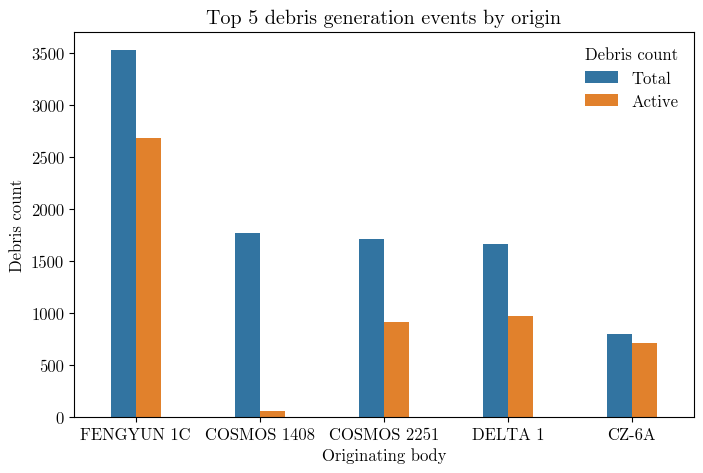

In [6]:
with requests.Session() as session:
    postCheck = session.post(uriBase + requestLogin, data = siteCred)
    if postCheck.status_code != 200:
        raise HandleError('POST')

    # Requests for DEBRIS data where LAUNCH_DATE != null
    response1 = session.get(uriBase + requestQuery + objectDebris + predicate1 + orderBy)
    if response1.status_code != 200:
        raise HandleError('GET')
    
    data1 = response1.text

    dataFrame1 = pd.read_json(io.StringIO(data1))

    """
    Using any available fonts is permissible for the plots, 
    but I chose CMU Serif for aesthetic reasons.
    For Ubuntu, you can install the font package fonts-cmu 
    (using sudo apt install fonts-cmu), which contains the fonts.
    """
    # plt.rcParams['font.family'] = "CMU Serif"
    # plt.rcParams['font.size'] = 12   

    dataFrame1['OBJECT_NAME'] = dataFrame1['OBJECT_NAME'].str.replace('DEB', '')
    dataFrame1['OBJECT_NAME'] = dataFrame1['OBJECT_NAME'].str.replace(r'\s+\*', '*', regex = True)
    dataFrame1['OBJECT_NAME'] = dataFrame1['OBJECT_NAME'].str.replace(r'\s+\(YO\)', '', regex = True)
    dataFrame1['OBJECT_NAME'] = dataFrame1['OBJECT_NAME'].str.strip('*').str.strip()

    debrisCount = dataFrame1['OBJECT_NAME'].value_counts()
    activeCount = dataFrame1[dataFrame1['DECAY_DATE'].isnull()]['OBJECT_NAME'].value_counts()

    topFive = debrisCount.head(5).index

    objectCount = pd.DataFrame({
        'NAME': topFive,
        'Total': debrisCount[topFive],
        'Active': activeCount.reindex(topFive)
    })

    plt.figure(figsize = (8, 5))

    # Plots the top 5 debris generation events by origin
    sns.barplot(data = objectCount.melt(id_vars = 'NAME', var_name = 'TYPE', value_name = 'COUNT'),
                x = 'NAME', y = 'COUNT', hue = 'TYPE', width = 0.4)
    
    plt.xlabel("Originating body")
    plt.ylabel("Debris count")
    plt.title("Top 5 debris generation events by origin")

    plt.legend(title = "Debris count", frameon = False)

    plt.show()

session.close()